# EMG Gesture Recognition
> Gati Aher  
> SP2021: Neurotechnology: Brains and Machines

## Abstract

This notebook performs generalized human gesture classification on a balanced dataset of three gestures (rock, paper, scissors) from 10 subjects. Each subject performed 18 trials of duration 3 seconds. Fouier transform was used to select a filter frequency, a fast and simple feature set (mean absolute value, root mean squared, slope sign change, waveform length, Hjorth parameters) was extracted from overlapping sliding windows of 200 ms with stride length of 4 ms over 3 channels of sEMG data. The resulting feature vectors were fed into a neural net with one hidden layer which achieved 80% test set classification accuracy, 53% validation set classification accuracy.

## Introduction

Human Gesture Recognition models have many applications, such as intelligent prostheses, sign language recognition, rehabilitation devices, and external device control. These systems aim to determine what gesture was performed and when the gesture was performed. For these models, a common method of acquiring data is using surface electromyography sensors (sEMG), as they are non-invasive,do not constrain movement, and are not affected by variation of light, position, or orientation of hand. Furthermore, EMGs not only capture data related to execution of a hand movement, but also extract the intention of the hand movement. This last property means these sensors can also be used with amputees, who may interact with the sensor via intentions of moving in certain ways.

## Biological Background

sEMGs use electrodes to pick up on the electrical manifestation of contracting muscles. The basic functional unit of the muscle contraction is a motor unit, which consists of a single alpha motor neuron, and all the fibers it communicates with. The muscle fibers contract when the action potentials of the motor nerve reaches a depolarization threshold. The depolarization propagates in both directions along the fiber and generates an electromagnetic field. The motor unit action potential is the summation of the individual muscle action potentials for all the fibers of a single motor unit. 

The sEMG is inherently a complex and noisy signal. It measures the algebraic summation of all the entwined motor unit action potentials within the pick-up area as they vary in space, amplitude, and duration due to the differences in the distance of the electrode to the muscle fibers and the length of the axons extending to the muscle fibers. Furthermore, this sEMG signal is highly variable between individuals as the number of motor units per muscle is variable throughout the body and may vary from one subject to another.


## Mathematical Background

There are two types of muscle contractions: static and dynamic. In a static contraction, the muscles fibers contract to hold a steady position and do not change in length. Generally, the signals of a static contraction make a stationary time series because  the mean and covariance do not change over time. If factors such as muscular fatigue and temperature affect the EMG, the signal can become non-stationary. A dynamic contraction occurs when there are changes in the lengths of the muscle fibers and the joints are in motion. The signals of a dynamic contraction makes a non-stationary time series, whose mathematical model is similar to the amplitude modulation. For each gesture, the generated EMG data has two states, transient and steady, Short-term gestures generate more EMG data in the transient state than in the steady state, as most of the time is spent in the transition into holding and releasing the gesture.

Mathematical models of EMG are generally not used in Human Gesture Recognition models due to the difficulty of parameter estimation in non-stationary processes. Machine learning methods are widely used because they can infer a solution for non-stationary processes. 



## Data Acquisition

Data was collected using a 3 channel sEMG sensor with a sampling rate of 500 Hz. Each of 10 participants was recorded for 18 trials, in which there were 6 trials for each of three gestures (rock, paper, scissors). Each trial was 3 seconds long with a 30 second break between trials.

![rock](./img/gesture_set.jpeg)

In [6]:
import numpy as np
import pandas as pd

import gdown
from scipy.io import loadmat

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from scipy.signal import butter, sosfilt

from sklearn.manifold import TSNE

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from sklearn.metrics import confusion_matrix
import itertools

In [7]:
random_seed = 42
np.random.seed(random_seed)

In [8]:
def get_X_y_srate(filename):
    """
    Given filename return data and labels.
    Note: Assumes that the trials are grouped by person.

    Input:
        filename: location of .mat datafile

    Output:
        X: ndarray with shape (trial x time points x channels)
        y: ndarray with shape (trial x 2). First column is gesture labels, second column is people labels
        srate: sampling rate in Hz
    """
    matfile = loadmat(filename, struct_as_record=True)
    EMG = matfile['EMG']

    # number of channels
    print("nbchan", EMG['nbchan'][0, 0][0, 0])

    # timespan
    alltimes = EMG['alltimes'][0, 0][:, 0]
    print("alltimes", alltimes)

    # data, order (trial x time points x channels)
    X = np.swapaxes(EMG['data'][0, 0].astype(np.float32), 0, -1)

    # labels, order (gesture code, subject code)
    epochlabels = np.moveaxis(EMG['epochlabels'][0, 0], -1, 0)
    y = np.zeros((epochlabels.shape[0], 2))
    # add gesture code associated with each trial
    gesture_map = {
        'none': 0,
        "['rock']": 1,
        "['paper']": 2,
        "['scissors']": 3
    }
    for i, v in enumerate(epochlabels):
        y[i, 0] = gesture_map[str(v[0])]
    # add person associated with each trial
    y[:, 1] = np.repeat(list(range(10)), 18)
    y = y.astype(np.int64)

    # sampling rate
    srate = EMG['srate'][0, 0][0, 0]

    return X, y, srate

filename = 'data/allEMGdata-JuniperSun-0323new.mat'
# urlname = 'https://drive.google.com/uc?id=1S4R8OsJJK3F_YbXecFfSdviNY5Ro0geY'
# gdown.download(urlname, filename,False)

X, y, srate = get_X_y_srate(filename)
print("X.shape", X.shape)
print("y.shape", y.shape)
print("srate", srate)
print()
# length of data collection span in seconds
timespan = X.shape[1] / srate
print("timespan", timespan)
# space between each time point in seconds
timeperiod = 1 / srate
print("timeperiod", timeperiod)
timeaxis = np.linspace(0, timespan, num=X.shape[1])
print("timeaxis", timeaxis)

nbchan 3
alltimes [   0    2    4 ... 3007 3008 3010]
X.shape (180, 1500, 3)
y.shape (180, 2)
srate 500

timespan 3.0
timeperiod 0.002
timeaxis [0.00000000e+00 2.00133422e-03 4.00266845e-03 ... 2.99599733e+00
 2.99799867e+00 3.00000000e+00]


In [9]:
def plot_trial(timeseries, timeaxis, title="EMG"):
    plt.figure()
    plt.subplot(3, 1, 1)
    plt.plot(timeaxis, timeseries[:, 0])
    plt.ylabel("Channel 0")

    plt.subplot(3, 1, 2)
    plt.plot(timeaxis, timeseries[:, 1])
    plt.ylabel("Channel 1")

    plt.subplot(3, 1, 3)
    plt.plot(timeaxis, timeseries[:, 2])
    plt.ylabel("Channel 2")
    
    plt.xlabel("Time (sec)")

    plt.suptitle(title)

def plot_channel_by_gesture(X, timeaxis, gesturelabels, title="EMGs"):
    plt.figure()
    plt.subplot(3, 1, 1)
    for i in range(X.shape[0]):
        if (gesturelabels[i] == 1):
            plt.plot(timeaxis, X[i, :], 'k')
    plt.ylabel("Rock")

    plt.subplot(3, 1, 2)
    for i in range(X.shape[0]):
        if (gesturelabels[i] == 2):
            plt.plot(timeaxis, X[i, :], 'k')
    plt.ylabel("Paper")

    plt.subplot(3, 1, 3)
    for i in range(X.shape[0]):
        if (gesturelabels[i] == 3):
            plt.plot(timeaxis, X[i, :], 'k')
    plt.ylabel("Scissors")
    plt.xlabel("Time (sec)")

    plt.suptitle(title)

## Data Splitting

The dataset is split into train, test, and validation sets. Each set should have the same ratio of gestures and subjects in order to be balanced.

* Train set: 4 repetitions of 3 gestures by 10 subjects (120 samples total)
* Test / Val set: 1 repetition of 3 gestures by 10 subjects (30 samples total)

X_train.shape (120, 1500, 3) y_train.shape (120, 2)
train: # of each gesture [ 0 40 40 40]
train: # of each subject [12 12 12 12 12 12 12 12 12 12]

X_test.shape (30, 1500, 3) y_test.shape (30, 2)
test: # of each gesture [ 0 10 10 10]
test: # of each subject [3 3 3 3 3 3 3 3 3 3]

X_val.shape (30, 1500, 3) y_val.shape (30, 2)
val: # of each gesture [ 0 10 10 10]
val: # of each subject [3 3 3 3 3 3 3 3 3 3]


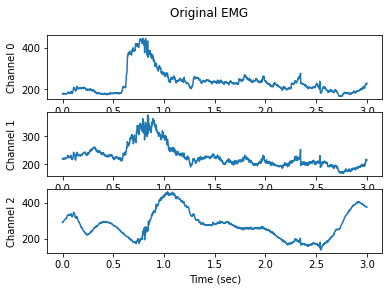

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=30, random_state=random_seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=30, random_state=random_seed)

print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("train: # of each gesture", np.bincount(y_train[:, 0]))
print("train: # of each subject", np.bincount(y_train[:, 1]))
print()
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)
print("test: # of each gesture", np.bincount(y_test[:, 0]))
print("test: # of each subject", np.bincount(y_test[:, 1]))
print()
print("X_val.shape", X_val.shape, "y_val.shape", y_val.shape)
print("val: # of each gesture", np.bincount(y_val[:, 0]))
print("val: # of each subject", np.bincount(y_val[:, 1]))

# representative sample
trial_idx = 0
channel_idx = 2

plot_trial(X_train[trial_idx, :, :], timeaxis, title="Original EMG")

## Preprocessing

The purpose of Preprocessing is to denoise the acquired signal for cleaner feature extraction.

First, for each trial, the observed signals are normalized so that its elements are scaled to the range \[0, 1\]. Computer calculations are done more effectively at this range.

Next, a high-pass filter is used to smooth the signal and reduce noise. Large low frequency noise in the signal can be attributed to electrode movement caused by the motion of the hand. This is noise and should be removed in order to get a clearer signal. Fourier Transform analysis identified that there was a strong low frequency below 5 Hz whose amplitude overshadowed other frequencies. Thus a 4th order high pass Butterworth filter with a cut-off frequency of 5 Hz was used.

Lastly, the EMG signal is rectified using an absolute value function. Since the raw EMG signal rapidly  oscillates between high and lows values, calculating statistics and averages on the raw signal lead to an uninformative, mean zero output. Rectifying the signal allows the true shape and magnitude of the EMG to be summarized by the features.

Here, plots of the training data are shown at different preprocessing steps. One representative sample is shown in blue. All the overlaid samples are shown in black to get a sense of the variation in the data. From the overlaid black plots, one can see that our samples are very varied and that gesture classes are not especially distinct, which will make classification on this data set difficult.


In [11]:
def normalize(X, min_val, max_val):
    """
    Scale matrix so all elements are in range [-1, 1].
    """
    X_std = (X - min_val) / (max_val - min_val)
    return X_std

def analyze_frequency_spectrum(timeseries, timeaxis, timeperiod, title="Fourier Transform"):
    """ Make a frequency plot for given timeseries
    
    Analyze frequency spectrum via FFT to pick filter cutoff frequency
    """
    freqX = np.fft.fftfreq(timeseries.shape[0], d=timeperiod)
    fX = np.fft.fft(timeseries, timeseries.shape[0])

    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(timeaxis, timeseries)
    plt.ylabel("Time-Domain")
    plt.xlabel("Time (sec)")

    plt.subplot(2, 1, 2)
    plt.plot(freqX[0:len(fX)//20], np.abs(fX)[0:len(fX)//20])
    plt.ylabel("Frequency-Domain")
    plt.xlabel("Frequency (Hz)")

    plt.suptitle(title)

In [12]:
train_min_val = np.amin(X)
train_max_val = np.amax(X)

# define a 4th order butterworth high-pass filter with a cutoff of 5 Hz
sos = butter(4, 5, btype='highpass', fs=srate, output='sos')

# scale to range [-1, 1]
X_train_std = normalize(X_train, train_min_val, train_max_val)

# filter
X_train_filt = np.zeros(X_train_std.shape)
for i in range(X_train_std.shape[0]):
    for c in range(X_train_std.shape[2]):
        X_train_filt[i, :, c] = sosfilt(sos, X_train_std[i, :, c])

# rectify
X_train_rect = np.abs(X_train_filt)

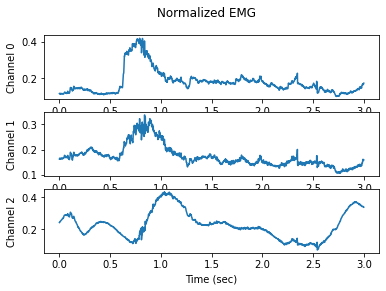

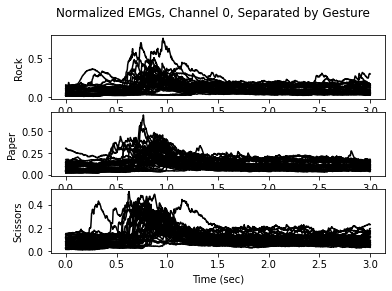

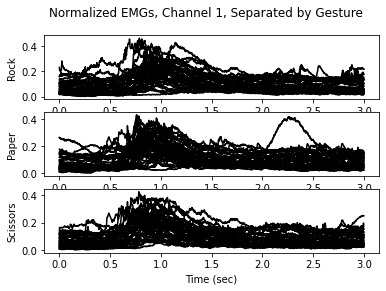

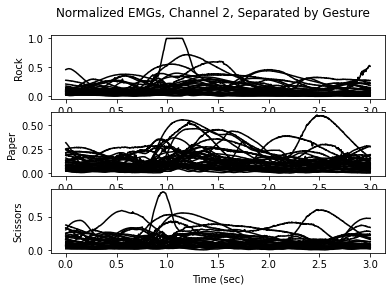

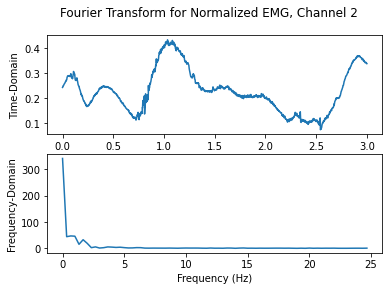

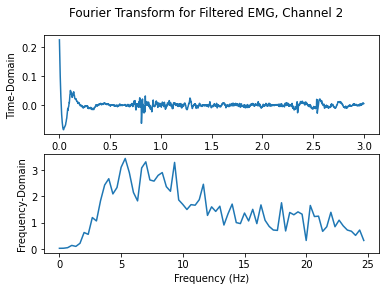

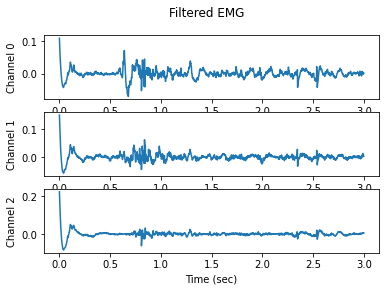

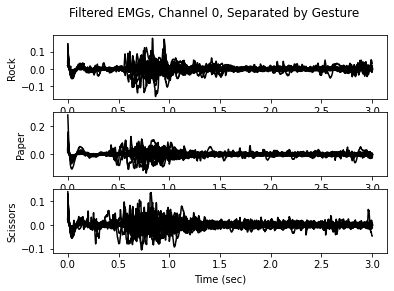

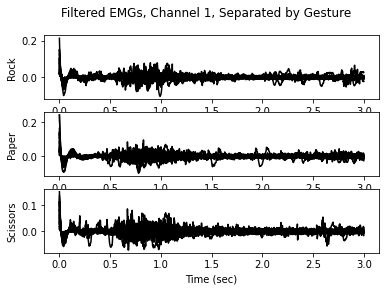

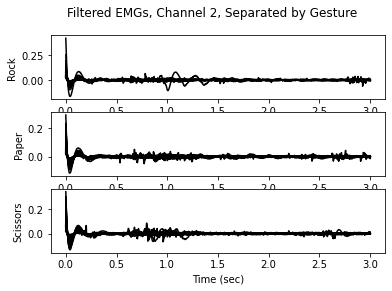

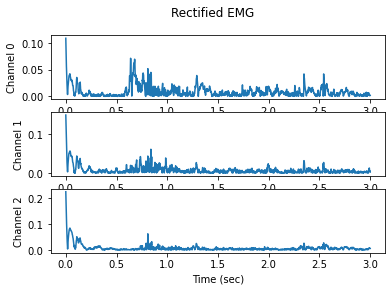

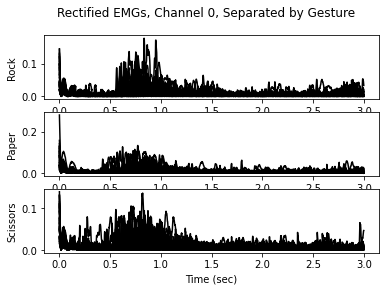

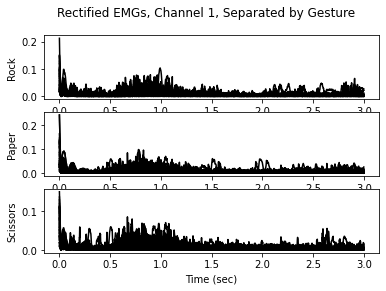

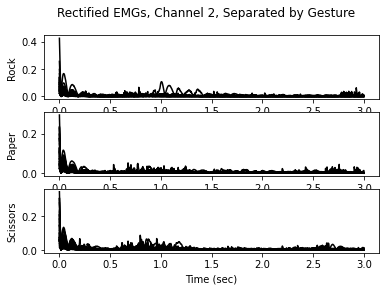

In [13]:
plot_trial(X_train_std[trial_idx, :, :], timeaxis, title="Normalized EMG")
plot_channel_by_gesture(X_train_std[:, :, 0], timeaxis, y[:, 0], title="Normalized EMGs, Channel 0, Separated by Gesture")
plot_channel_by_gesture(X_train_std[:, :, 1], timeaxis, y[:, 0], title="Normalized EMGs, Channel 1, Separated by Gesture")
plot_channel_by_gesture(X_train_std[:, :, 2], timeaxis, y[:, 0], title="Normalized EMGs, Channel 2, Separated by Gesture")

# analyze standard EMG frequency spectrum via FFT
analyze_frequency_spectrum(X_train_std[trial_idx, :, channel_idx], timeaxis, timeperiod, "Fourier Transform for Normalized EMG, Channel "+str(channel_idx))
# analyze filtered EMG frequency spectrum via FFT
analyze_frequency_spectrum(X_train_filt[trial_idx, :, channel_idx], timeaxis, timeperiod, "Fourier Transform for Filtered EMG, Channel "+str(channel_idx))

plot_trial(X_train_filt[trial_idx, :, :], timeaxis, title="Filtered EMG")
plot_channel_by_gesture(X_train_filt[:, :, 0], timeaxis, y[:, 0], title="Filtered EMGs, Channel 0, Separated by Gesture")
plot_channel_by_gesture(X_train_filt[:, :, 1], timeaxis, y[:, 0], title="Filtered EMGs, Channel 1, Separated by Gesture")
plot_channel_by_gesture(X_train_filt[:, :, 2], timeaxis, y[:, 0], title="Filtered EMGs, Channel 2, Separated by Gesture")

plot_trial(X_train_rect[trial_idx, :, :], timeaxis, title="Rectified EMG")
plot_channel_by_gesture(X_train_rect[:, :, 0], timeaxis, y[:, 0], title="Rectified EMGs, Channel 0, Separated by Gesture")
plot_channel_by_gesture(X_train_rect[:, :, 1], timeaxis, y[:, 0], title="Rectified EMGs, Channel 1, Separated by Gesture")
plot_channel_by_gesture(X_train_rect[:, :, 2], timeaxis, y[:, 0], title="Rectified EMGs, Channel 2, Separated by Gesture")

## Segmentation and Feature Extraction

Each trial was 3 seconds long, and data was collected at a sampling rate of 500 Hz, for a total of 1500 time points per trial spaced 2 miliseconds apart. As is common with time series analysis, an overlapping sliding window technique is used to segment each trial into windows of length 200ms with a stride length of 4 miliseconds. The following 7 features are calculated in each window: mean absolute value (MAV), root mean square (RMS), slope sign change (SSC), waveform length (WL), hjorth parameter activity (HP_A), hjorth parameter mobility (HP_M), hjorth parameter complexity (HP_C).

Feature set and window length are modeled after [(Zhang et. al., 2019)](https://www.mdpi.com/1424-8220/19/14/3170).

In [14]:
def MAV(timeseries):
    """
    The mean absolute value is one of the most commonly used values in sEMG signal analysis. The MAV feature is the average of the absolute values of the amplitude of the sEMG signal in the sliding window. It provides information about the muscle contraction level.
    """
    return np.mean(timeseries)

def RMS(timeseries):
    """
    The root mean square represents the mean power of the sEMG signal, which reflects the activity of muscles. 
    """
    return np.sqrt(np.mean(np.square(timeseries)))

def SSC(timeseries):
    """
    Slope sign change indicates the frequency information of the sEMG signal.
    """
    return np.sum(1 * (np.diff(np.sign(timeseries)) != 0))

def WL(timeseries):
    """
    Waveform length is the cumulative length of the sEMG signal waveform, which is related to waveform amplitude, frequency, and time and can be used to measure signal complexity. 
    """
    return np.sum(np.abs(np.diff(timeseries)))

def HP_A(timeseries):
    """
    Hjorth activity parameter represents the signal power, the variance of a time function. This can indicate the surface of power spectrum in the frequency domain. 
    """
    return np.var(timeseries, ddof=1)
    
def HP_M(timeseries):
    """
    Hjorth mobility parameter represents the mean frequency or the proportion of standard deviation of the power spectrum. This is defined as the square root of variance of the first derivative of the signal y(t) divided by variance of the signal y(t). 
    """
    return np.sqrt(HP_A(np.diff(timeseries))/HP_A(timeseries))

def HP_C(timeseries):
    """
    Hjorth Complexity parameter represents the change in frequency. The parameter compares the signal's similarity to a pure sine wave, where the value converges to 1 if the signal is more similar. 
    """
    return HP_M(np.diff(timeseries))/HP_M(timeseries)

def moving_window(X, windowsize, stridesize, timeperiod):
    windowlen = int(windowsize // timeperiod)
    stridelen = int(stridesize // timeperiod)
    print("windowlen", windowlen, "stridelen", stridelen)
    
    n_features = 7
    n_windows = (X.shape[1] - windowlen)//stridelen

    feature_matrix = np.zeros((X.shape[0], n_windows, n_features, X.shape[2]))
    for i in range(X.shape[0]):
        for c in range(X.shape[2]):
            for e in range(windowlen, X.shape[1], stridelen):
                s = e - windowlen
                w = s//stridelen
                window = X[i, s:e, c]
                feature_matrix[i, w, 0, c] = MAV(window)
                feature_matrix[i, w, 1, c] = RMS(window)
                feature_matrix[i, w, 2, c] = SSC(window)
                feature_matrix[i, w, 3, c] = WL(window)
                feature_matrix[i, w, 4, c] = HP_A(window)
                feature_matrix[i, w, 5, c] = HP_M(window)
                feature_matrix[i, w, 6, c] = HP_C(window)

                s += stridelen
                e += stridelen

    return feature_matrix

windowsize = 0.2 # seconds in a window
stridesize = 0.004 # seconds to shift window by
train_features = moving_window(X_train_rect, windowsize, stridesize, timeperiod)
print("train_features.shape", train_features.shape)

windowlen 100 stridelen 2
train_features.shape (120, 700, 7, 3)


T-distributed stochastic neighbor embedding (t-SNE) is used to visualize the high-dimensional feature vectors by giving each datapoint a location in a two-dimensional map. t-SNE is a probablistic and stochastic method that gives a different result every time it is run. t-SNE preserves local similarities, which means points close togther are similar (does not necessarily mean points far apart are very dissimilar).

I employ two types of sample divisions.

**Approach 1, flat samples:** the normal approach.

I keep the number of samples the same, and turn each sample into a flattened feature vector that is fed into the neural network. This feature set showed good clustering by gesture type and person type.

train_features_flat.shape (120, 14700)
train_labels.shape (120,)


Text(0.5, 1.0, 'TSNE plot of flat samples by person')

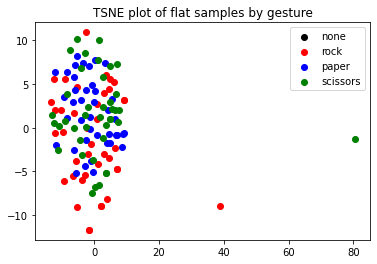

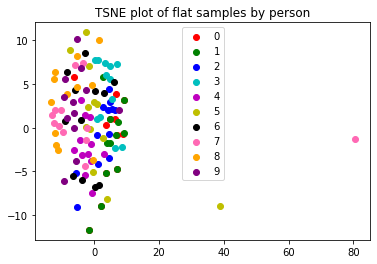

In [15]:
# approach 1 flat samples: keep number of samples the same, flatten feature vectors
train_labels = y_train[:, 0]
train_features_flat = train_features.reshape((train_features.shape[0], -1))
print("train_features_flat.shape", train_features_flat.shape)
print("train_labels.shape", train_labels.shape)

tsne = TSNE(n_components=2, random_state=random_seed)
train_flat_2d = tsne.fit_transform(train_features[:, :, :, :].reshape((train_features.shape[0], -1)))

# Evaluate features with T-SNE
plt.figure()
for i, c, label in zip([0, 1, 2, 3], ['k', 'r', 'b', 'g'], ["none", "rock", "paper", "scissors"]):
    plt.scatter(train_flat_2d[train_labels == i, 0], train_flat_2d[train_labels  == i, 1], c=c, label=label)
plt.legend()
plt.title("TSNE plot of flat samples by gesture")

plt.figure()
for i, c, label in zip([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'hotpink', 'orange', 'purple'], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
    plt.scatter(train_flat_2d[y_train[:, 1] == i, 0], train_flat_2d[y_train[:, 1]  == i, 1], c=c, label=label)
plt.legend()
plt.title("TSNE plot of flat samples by person")

**Approach 2, window samples:** the real-time approach used by [(Zhang et. al., 2019)](https://www.mdpi.com/1424-8220/19/14/3170).

I treat each window as a sample, turn each window into a flattened feature vector that is fed into the neural network. I plotted every 80th window (to get a good distribution of windows in time, see a non-overwhelming amount of points, and to run t-sne in a reasonable amount of time). This feature set has all the windows overlapping each other, not showing clustering by gesture. This is a bad feature set. When I ran the classifier on this set, the model stayed underfit and could not achieve a training accuracy of more than 40%.

[(Zhang et. al., 2019)](https://www.mdpi.com/1424-8220/19/14/3170) had very good accuracy using this feature set on their dataset. Their dataset may have had greater differences between the feature classes or less noise. Another reason for the discrepancy is that Zhang et. al. used a "muscle detection function" referenced from another paper I could not get access to. This function allowed them to accurately pinpoint where a gesture started and ended, and they did some preprocessing based on that result before making the window samples.

train_features_windows.shape (84000, 21)
train_labels_windows.shape (84000,)


Text(0.5, 1.0, 'TSNE plot of features in window samples')

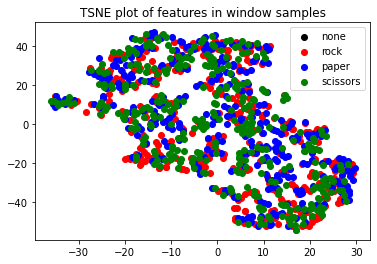

In [16]:
# approach 2 window samples: make each window a sample
train_labels_windows = np.repeat(y_train[:, 0], train_features.shape[1])
train_features_windows = train_features.reshape((train_features.shape[0]*train_features.shape[1], -1))
print("train_features_windows.shape", train_features_windows.shape)
print("train_labels_windows.shape", train_labels_windows.shape)

# Evaluate features with T-SNE
tsne_idx_skip = 80
tsne = TSNE(n_components=2, random_state=random_seed)
train_windows_2d = tsne.fit_transform(train_features_windows[::tsne_idx_skip, :])

plt.figure()
for i, c, label in zip([0, 1, 2, 3], ['k', 'r', 'b', 'g'], ["none", "rock", "paper", "scissors"]):
    plt.scatter(train_windows_2d[train_labels_windows[::tsne_idx_skip] == i, 0], train_windows_2d[train_labels_windows[::tsne_idx_skip] == i, 1], c=c, label=label)
plt.legend()
plt.title("TSNE plot of features in window samples")

## Classification

The same preprocessing and feature extraction is applied to the test data. The classifier is a neural network with a single hidden layer where the number of nodes is half the number of features [(Zhang et. al., 2019)](https://www.mdpi.com/1424-8220/19/14/3170).

In [17]:
# prepare test set

# scale to range [-1, 1]
X_test_std = normalize(X_test, train_min_val, train_max_val)

# filter
X_test_filt = np.zeros(X_test_std.shape)
for i in range(X_test_std.shape[0]):
    for c in range(X_test_std.shape[2]):
        X_test_filt[i, :, c] = sosfilt(sos, X_test_std[i, :, c])

# rectify
X_test_rect = np.abs(X_test_filt)

# segmentation and feature extraction
test_features = moving_window(X_test_rect, windowsize, stridesize, timeperiod)
print("test_features.shape", test_features.shape)

# approach 1 flat samples: keep number of samples the same, flatten feature vectors
test_labels = y_test[:, 0]
test_features_flat = test_features.reshape((test_features.shape[0], -1))
print("test_features_flat.shape", test_features_flat.shape)
print("test_labels.shape", test_labels.shape)

# approach 2 window samples: make each window a sample
test_labels_windows = np.repeat(y_test[:, 0], test_features.shape[1])
test_features_windows = test_features.reshape((test_features.shape[0]*test_features.shape[1], -1))
print("test_features_windows.shape", test_features_windows.shape)
print("test_labels_windows.shape", test_labels_windows.shape)

windowlen 100 stridelen 2
test_features.shape (30, 700, 7, 3)
test_features_flat.shape (30, 14700)
test_labels.shape (30,)
test_features_windows.shape (21000, 21)
test_labels_windows.shape (21000,)


In [18]:
# Build the model
num_features = train_features_flat.shape[1]

model = Sequential([
  Dense(num_features//2, activation='relu', input_shape=(num_features,)),
  Dense(4, activation='softmax'),
])

model.summary()

# Compile the model
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

checkpoint = ModelCheckpoint('models/model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

# Train the model
hist = model.fit(
  train_features_flat,
  to_categorical(train_labels),
  epochs=15,
  batch_size=20,
  validation_data=(test_features_flat, to_categorical(test_labels)),
  callbacks=[checkpoint]
)

# # Train the model on window features
# hist = model.fit(
#   train_features_windows,
#   to_categorical(train_labels_windows),
#   epochs=10,
#   batch_size=10,
#   validation_data=(test_features_windows, to_categorical(test_labels_windows))
# )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 7350)              108052350 
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 29404     
Total params: 108,081,754
Trainable params: 108,081,754
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
6/6 [==============================] - ETA: 0s - loss: 53.0136 - accuracy: 0.3417
Epoch 00001: val_loss improved from inf to 26.58832, saving model to models/model-001-0.341667-0.300000.h5
6/6 [==============================] - 6s 932ms/step - loss: 53.0136 - accuracy: 0.3417 - val_loss: 26.5883 - val_accuracy: 0.3000
Epoch 2/15
6/6 [==============================] - ETA: 0s - loss: 15.8974 - accuracy: 0.4417
Epoch 00002: val_loss improved from 26.58832 to 14.53294, saving model to models

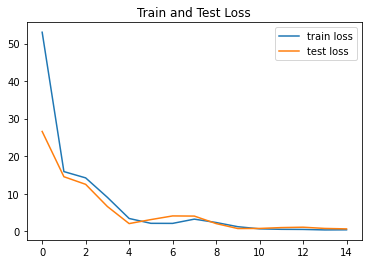

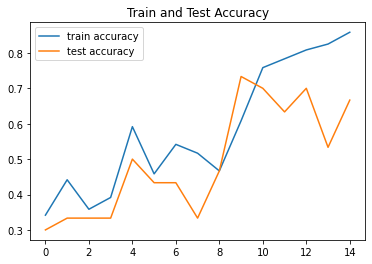

In [19]:
hist.history
N = np.arange(0, len(hist.history['loss']))

plt.figure()
plt.plot(N, hist.history['loss'], label="train loss")
plt.plot(N, hist.history['val_loss'], label="test loss")
plt.title("Train and Test Loss")
plt.legend()
plt.savefig("img/loss_window_samples.png")

plt.figure()
plt.plot(N, hist.history['accuracy'], label="train accuracy")
plt.plot(N, hist.history['val_accuracy'], label="test accuracy")
plt.title("Train and Test Accuracy")
plt.savefig("img/acc_window_samples.png")
plt.legend()

In [20]:
# to load model from disk
loaded_model = load_model('models/model-013-0.825000-0.800000.h5')
print(test_features_flat.shape, test_labels.shape)
score = loaded_model.evaluate(test_features_flat, to_categorical(test_labels), verbose=0)
y_test_pred = loaded_model.predict(test_features_flat)

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

(30, 14700) (30,)
accuracy: 80.00%


Confusion matrix, without normalization
[[9 1 0]
 [1 9 0]
 [3 1 6]]


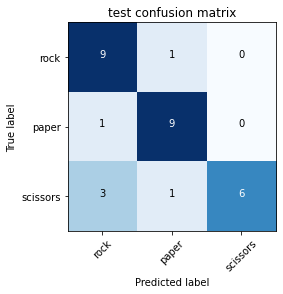

In [25]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    plt.imshow(cm, cmap='Blues',interpolation="nearest")
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_test = confusion_matrix(test_labels, y_test_pred.argmax(axis=1))
plot_confusion_matrix(cm_test, ["rock", "paper", "scissors"], title="test confusion matrix")

Model batch size, epoches, and hyperparameters were adjusted based on performance on test set.

Finally, model performance is evaluated on validation set.

windowlen 100 stridelen 2
val_features.shape (30, 700, 7, 3)
val_features_flat.shape (30, 14700)
val_labels.shape (30,)
val_features_windows.shape (21000, 21)
val_labels_windows.shape (21000,)
accuracy: 53.33%
Confusion matrix, without normalization
[[4 6 0]
 [6 2 2]
 [3 3 4]]


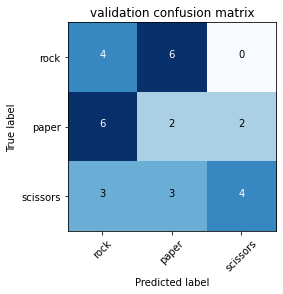

In [26]:
# prepare validation set

# scale to range [-1, 1]
X_val_std = normalize(X_val, train_min_val, train_max_val)

# filter
X_val_filt = np.zeros(X_val_std.shape)
for i in range(X_val_std.shape[0]):
    for c in range(X_val_std.shape[2]):
        X_val_filt[i, :, c] = sosfilt(sos, X_val_std[i, :, c])

# rectify
X_val_rect = np.abs(X_val_filt)

# segmentation and feature extraction
val_features = moving_window(X_val_rect, windowsize, stridesize, timeperiod)
print("val_features.shape", val_features.shape)

# approach 1 flat samples: keep number of samples the same, flatten feature vectors
val_labels = y_val[:, 0]
val_features_flat = val_features.reshape((val_features.shape[0], -1))
print("val_features_flat.shape", val_features_flat.shape)
print("val_labels.shape", val_labels.shape)

# approach 2 window samples: make each window a sample
val_labels_windows = np.repeat(y_val[:, 0], val_features.shape[1])
val_features_windows = val_features.reshape((val_features.shape[0]*val_features.shape[1], -1))
print("val_features_windows.shape", val_features_windows.shape)
print("val_labels_windows.shape", val_labels_windows.shape)

# evaluate
score = loaded_model.evaluate(val_features_flat, to_categorical(val_labels), verbose=0)
y_val_pred = loaded_model.predict(test_features_flat)

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

cm_val = confusion_matrix(val_labels, y_val_pred.argmax(axis=1))
plot_confusion_matrix(cm_val, ["rock", "paper", "scissors"], title="validation confusion matrix")

## Conclusions

Although train and test performance was high, validation accuracy of the best model was low, showing that the model was overfit.

## References

1. Zhang Z, Yang K, Qian J, Zhang L. Real-Time Surface EMG Pattern Recognition for Hand Gestures Based on an Artificial Neural Network. Sensors (Basel). 2019;19(14):3170. Published 2019 Jul 18. https://doi.org/10.3390/s19143170
2. Jaramillo-Yánez A, Benalcázar ME, Mena-Maldonado E. Real-Time Hand Gesture Recognition Using Surface Electromyography and Machine Learning: A Systematic Literature Review. Sensors. 2020; 20(9):2467. https://doi.org/10.3390/s20092467
3. Rose, William. “Electromyogram Analysis.” Mathematics and Signal Processing for Biomechanics. https://www1.udel.edu/biology/rosewc/kaap686/notes/EMG%20analysis.pdf

